In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dpt1-dataset/DPT1.xlsx
/kaggle/input/lct1-dataset/LCT1.xlsx
/kaggle/input/lct2-dataset/LCT2.xlsx
/kaggle/input/lpt-2-dataset/LPT 2.xlsx
/kaggle/input/lpt-1-dataset/LPT 1.xlsx


In [2]:
!pip install mpl-chord-diagram
!pip install eli5

  Preparing metadata (setup.py) ... done
  Created wheel for mpl-chord-diagram: filename=mpl_chord_diagram-0.4.1-py2.py3-none-any.whl size=16686 sha256=87c76a1a821a697bfda215f4a0b76e7a43f0016267969aac52f72d215a5796cb
  Stored in directory: /root/.cache/pip/wheels/e3/63/c5/7c88ede73f3c7d4921eeb8f1d620a7c7311992c4a452442334
Successfully built mpl-chord-diagram


In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.utils import resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error 
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
import eli5
from mpl_chord_diagram import chord_diagram
import re

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
2024-04-01 06:40:26.242420: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 06:40:26.242550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 06:40:26.494019: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
np.random.seed(45)

In [5]:
df = pd.read_excel("/kaggle/input/lct1-dataset/LCT1.xlsx")

In [6]:
df.head()

PATIENT      DOSE  LOC  MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]  \
0   PT8.nii  1.208252    2                                     3727.125   
1  PT12.nii  1.279350    1                                    23006.250   
2  PT12.nii  1.056145    1                                    23929.875   
3  PT12.nii  0.720256    1                                    11416.500   
4  PT12.nii  0.990299    1                                   228811.500   

   MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]  \
0                                             3969   
1                                            23409   
2                                            24354   
3                                            11718   
4                                           231066   

   MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]  \
0                                         147   
1                                         867   
2                                         902   
3                                         434   
4                                        8558   

   MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]  \
0                                1664.202755   
1                                5212.513042   
2                                5658.314068   
3                                3443.120258   
4                               51750.836540   

   MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]  \
0                                           0.446511   
1                                           0.226569   
2                                           0.236454   
3                                           0.301592   
4                                           0.226172   

   MORPHOLOGICAL_Compacity(IBSI:No)[]  \
0                           18.215261   
1                           16.357800   
2                           17.786486   
3                           17.696823   
4                           51.451520   

   MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]  ...  \
0                                 0.030973  ...   
1                                 0.034491  ...   
2                                 0.031720  ...   
3                                 0.031881  ...   
4                                 0.010965  ...   

   GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)  \
0                                        0.000541   
1                                        0.000117   
2                                        0.000118   
3                                        0.000116   
4                                        0.000128   

   GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)  \
0                                      7707.934426   
1                                     51392.086820   
2                                     63673.115330   
3                                     65774.619350   
4                                     71267.707700   

   GLSZM_GreyLevelNonUniformity(IBSI:JNSA)  \
0                                 2.573770   
1                                 9.027907   
2                                10.013657   
3                                 6.187097   
4                                56.844047   

   GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)  \
0                                           0.021096   
1                                           0.013997   
2                                           0.015195   
3                                           0.019958   
4                                           0.008847   

   GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)  \
0                               88.704918   
1                              402.764341   
2                              424.474962   
3                              183.070968   
4                             4326.368093   

   GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)  \
0                                          0.727089   
1                                          0.624441   
2                                          0.644120   
3   

In [7]:
df.shape

(27, 123)

In [8]:
df.dtypes

PATIENT                                              object
DOSE                                                float64
LOC                                                   int64
MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]         float64
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]       int64
                                                     ...   
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    float64
GLSZM_ZonePercentage(IBSI:P30P)                     float64
GLSZM_GreyLevelVariance(IBSI:BYLV)                  float64
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   float64
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    float64
Length: 123, dtype: object

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Columns: 123 entries, PATIENT to GLSZM_ZoneSizeEntropy(IBSI:GU8N)
dtypes: float64(106), int64(16), object(1)
memory usage: 26.1+ KB


In [10]:
df.isna().sum()

PATIENT                                             0
DOSE                                                0
LOC                                                 0
MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]         0
MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]     0
                                                   ..
GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)    0
GLSZM_ZonePercentage(IBSI:P30P)                     0
GLSZM_GreyLevelVariance(IBSI:BYLV)                  0
GLSZM_ZoneSizeVariance(IBSI:3NSA)                   0
GLSZM_ZoneSizeEntropy(IBSI:GU8N)                    0
Length: 123, dtype: int64

In [11]:
df.drop("PATIENT", axis = 1, inplace=True)

In [12]:
df.columns

Index(['DOSE', 'LOC', 'MORPHOLO+B1:BO1GICAL_Volume(IBSI:RNU0)[mm3]',
       'MORPHOLOGICAL_ApproximateVolume(IBSI:YEKZ)[mm3]',
       'MORPHOLOGICAL_voxelsCounting(IBSI:No)[#vx]',
       'MORPHOLOGICAL_SurfaceArea(IBSI:C0JK)[mm2]',
       'MORPHOLOGICAL_SurfaceToVolumeRatio(IBSI:2PR5)[mm]',
       'MORPHOLOGICAL_Compacity(IBSI:No)[]',
       'MORPHOLOGICAL_Compactness1(IBSI:SKGS)[]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       ...
       'GLSZM_LargeZoneLowGreyLevelEmphasis(IBSI:YH51)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLSZM_GreyLevelNonUniformity(IBSI:JNSA)',
       'GLSZM_NormalisedGreyLevelNonUniformity(IBSI:Y1RO)',
       'GLSZM_ZoneSizeNonUniformity(IBSI:4JP3)',
       'GLSZM_NormalisedZoneSizeNonUniformity(IBSI:VB3A)',
       'GLSZM_ZonePercentage(IBSI:P30P)', 'GLSZM_GreyLevelVariance(IBSI:BYLV)',
       'GLSZM_ZoneSizeVariance(IBSI:3NSA)',
       'GLSZM_ZoneSizeEntropy(IBSI:GU8N)'],
      dtype='object', length=122)

<Axes: >

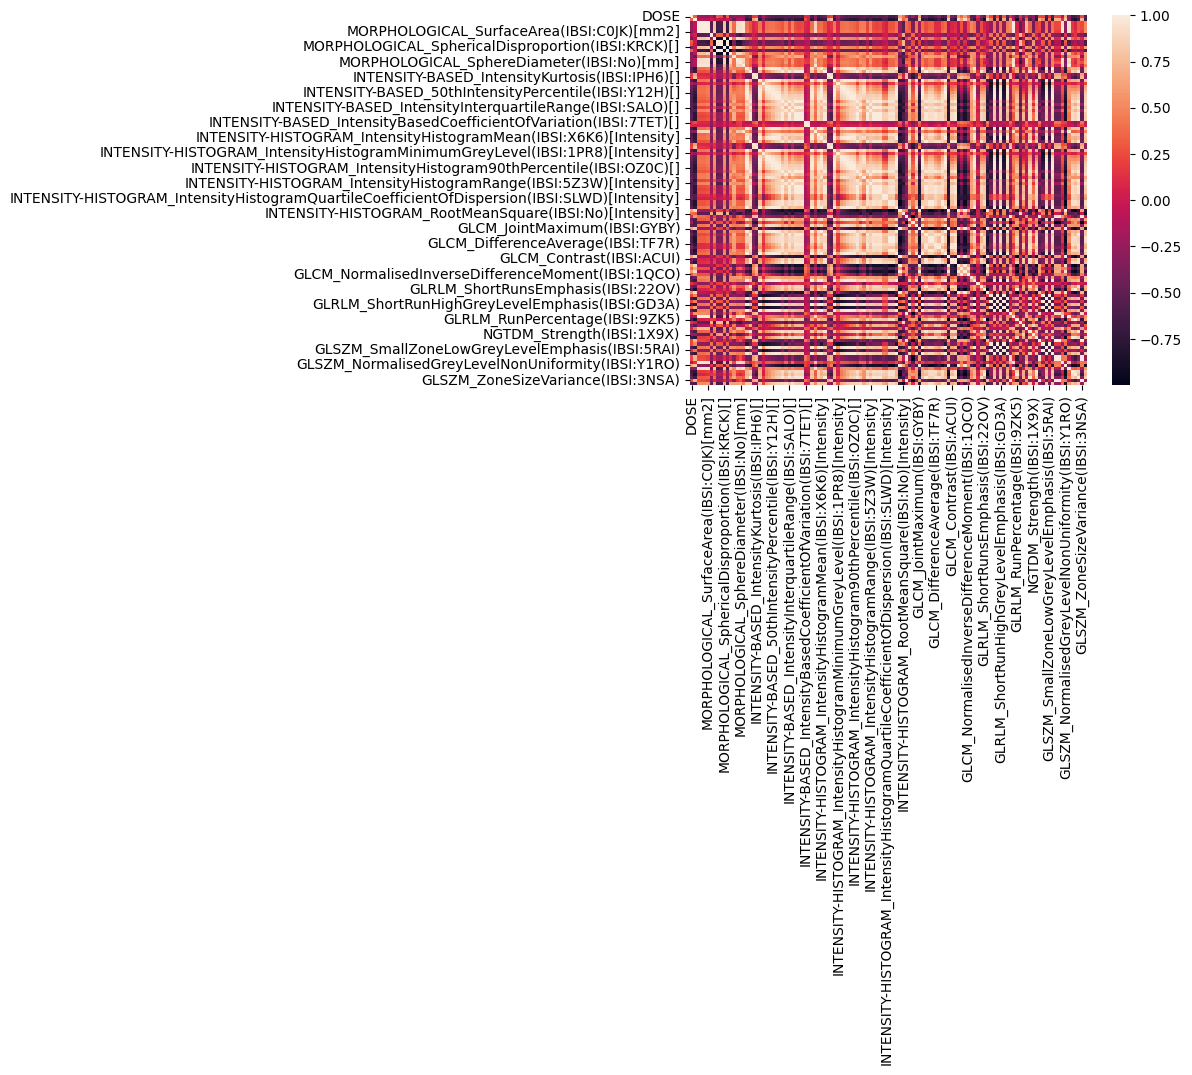

In [13]:
sns.heatmap(df.corr())

In [14]:
def calculate_scores(y, y_pred):
    # Calculate metrics
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    
    return r2, mae, mse

In [15]:
# Calculate and print mean scores for each metric
def print_scores(mode, r2_scores, mae_scores, mse_scores, rmse_scores):
    print("\nMean", mode, "Scores:")
    print("Mean R2 Score:", np.mean(r2_scores))
    print("Mean MAE:", np.mean(mae_scores))
    print("Mean MSE:", np.mean(mse_scores))
    print("Mean RMSE:", np.mean(rmse_scores))
    print()

In [16]:
# This function evaluates the performance of a model over multiple iterations
# using bootstrapping and KFold cross-validation with 5 splits.

def evaluate_model(X, y, model, n_iterations=500, sample_size=0.6, print_results=True):
    r2_train_scores = []
    mae_train_scores = []
    mse_train_scores = []
    rmse_train_scores = []

    r2_test_scores = []
    mae_test_scores = []
    mse_test_scores = []
    rmse_test_scores = []
    
    # K-fold cross-validation with k = 5
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for i in range(n_iterations):
        
        # Bootstrap resampling of the data
        X_boot, y_boot = resample(X, y, replace=True, n_samples=int(sample_size * len(X)), random_state=16)
        
        r2_train_fold_scores = []
        mae_train_fold_scores = []
        mse_train_fold_scores = []
        
        r2_test_fold_scores = []
        mae_test_fold_scores = []
        mse_test_fold_scores = []
        
        for fold, (train_index, test_index) in enumerate(kf.split(X_boot), 1):
            X_train, X_test = X_boot[train_index], X_boot[test_index]
            y_train, y_test = y_boot.iloc[train_index], y_boot.iloc[test_index]
            
            # Fit the model
            model.fit(X_train, y_train)
            
            # Predict
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)

            # Calculate metrics
            r2_train, mae_train, mse_train = calculate_scores(y_train, y_train_pred)
            
            r2_test, mae_test, mse_test = calculate_scores(y_test, y_test_pred)
            
            # Append scores for this fold
            r2_train_fold_scores.append(r2_train)
            mae_train_fold_scores.append(mae_train)
            mse_train_fold_scores.append(mse_train)
            
            r2_test_fold_scores.append(r2_test)
            mae_test_fold_scores.append(mae_test)
            mse_test_fold_scores.append(mse_test)
            

        # Append mean scores for this iteration
        r2_train_scores.append(np.mean(r2_train_fold_scores))
        mae_train_scores.append(np.mean(mae_train_fold_scores))
        mse_train_scores.append(np.mean(mse_train_fold_scores))
        rmse_train_scores.append(np.sqrt(np.mean(mse_train_fold_scores)))
        
        r2_test_scores.append(np.mean(r2_test_fold_scores))
        mae_test_scores.append(np.mean(mae_test_fold_scores))
        mse_test_scores.append(np.mean(mse_test_fold_scores))
        rmse_test_scores.append(np.sqrt(np.mean(mse_test_fold_scores)))

    if (print_results):
        # Train scores
        print_scores('Train', r2_train_scores, mae_train_scores, mse_train_scores, rmse_train_scores)
        
        # Test scores
        print_scores('Test', r2_test_scores, mae_test_scores, mse_test_scores, rmse_test_scores)
    
    return np.mean(r2_test_scores), np.mean(mse_test_scores)

In [17]:
def evaluate_based_on_feature_number(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Score')
    plt.title('Model Performance vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:

def evaluate_based_on_feature_number2(X_sorted, y, model):
    num_features_list = []
    r2_scores = []
    mse_scores = []

    # Iterate over different numbers of selected features
    for num_features in range(X_sorted.shape[1], 1, -1):
        # Select top num_features features
        X_selected = X_sorted[:, :num_features]
        
        # We set bootstrapping iterations to 10 for reducing complexity
        # since the plot is just for estimation and not final evaluation
        r2, mse = evaluate_model(X_selected, y, model, n_iterations=10, print_results=False)    
        
        num_features_list.append(num_features)
        r2_scores.append(r2)
        mse_scores.append(mse)

    # Plot R^2 Score
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, r2_scores, marker='o', label='R^2 Score')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('R^2 Score')
    plt.title('R^2 Score vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Mean Squared Error (MSE)
    plt.figure(figsize=(10, 6))
    plt.plot(num_features_list, mse_scores, marker='x', label='Mean Squared Error')
    plt.xlabel('Number of Selected Features')
    plt.ylabel('Mean Squared Error')
    plt.title('Mean Squared Error vs. Number of Selected Features')
    plt.xticks(num_features_list)
    plt.legend()
    plt.grid(True)
    plt.show()

In [19]:
def one_hot_encoding(df, feature_name):
    if feature_name in df.columns:
        encoder = OneHotEncoder(sparse_output=False)
        encoded_data = encoder.fit_transform(df[[feature_name]])
        one_hot_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([feature_name]))
        df = pd.concat([df, one_hot_df], axis=1)
        df = df.drop(feature_name, axis=1)
    return df   

In [20]:
# For simpler visualization
def get_simple_feature_name(feature_names):
    simple_names = []
    for feature_name in feature_names:
        simple_name=feature_name
        pattern = r'\((.*)'
        match = re.search(pattern, feature_name)
        if match:
            simple_name = match.group(1)
            if simple_name in simple_names:
                last_underscore_index = feature_name.rfind('_')
                simple_name = feature_name[last_underscore_index:] if last_underscore_index != -1 else feature_name
        simple_names.append(simple_name)
    return simple_names

In [21]:
def hist_plot(df):
    df_renamed = df.copy()
    df_renamed.columns = get_simple_feature_name(df.columns)
    df_renamed.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [22]:
def pair_plot(X, y):
    X_renamed = X.copy()
    X_renamed.columns = get_simple_feature_name(X.columns)
    y_df = y.to_frame().rename(columns={0: 'Dose'})
    df = pd.concat([X_renamed, y_df], axis=1)
    for i in range(0, len(df.columns), 5):
        sns.pairplot(data=df,
                     x_vars=df.columns[i:i+5],
                     y_vars=['DOSE'])

In [23]:
def plot_chord_diagram(X):
    fig, ax = plt.subplots(figsize=(12, 12))
    chord_diagram(X.corr(), names=get_simple_feature_name(X.columns), ax=ax, rotation=0, fontsize=8)
    plt.show()

In [24]:
y=df['DOSE']
X=df.drop('DOSE', axis=1)

In [25]:
X_scaled = StandardScaler().fit_transform(X)

Section 1: Three-Step Feature Selection using Lasso Regression, Random Forest and Recursive Feature Elimination (RFE) 

Model: XGBRegressor trained using k fold cross-validation with bootstrapping

In [26]:
# Step 1: Initial feature selection using Lasso regression
# Eliminating features with lasso coef of 0
lasso = Lasso(alpha=0.05, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]
for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (-5.431936)
2. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (-0.000000)
3. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (-0.000000)
4. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity] (-0.000000)
5. Feature INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[] (-0.000000)
6. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[] (0.000000)
7. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity] (-0.000000)
8. Feature INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity] (-0.000000)
9. Feature GLCM_Contrast(IBSI:ACUI) (-0.159213)
10. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX) (-0.000000)
11. Feature GLCM_Correlation(IBSI:NI2N) (-0.000000)
12. Feature GLCM_ClusterShade(IBSI:7NFM) (-0.000000)
13. Feature GLCM_ClusterProminence(IBSI:AE86) (0.175479)
14. Feature GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO) (-0.000000)
15. Feature NGTDM_Coarseness(IBSI:QCDE) (-0.000000)


In [27]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [28]:
X_selected = X[selected_features]

In [29]:
X_selected.columns

Index(['LOC', 'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterShade(IBSI:7NFM)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO)',
       'NGTDM_Coarseness(IBSI:QCDE)', 'NGTDM_Contrast(IBSI:65HE)',
       'GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)'],
      dtype='object')

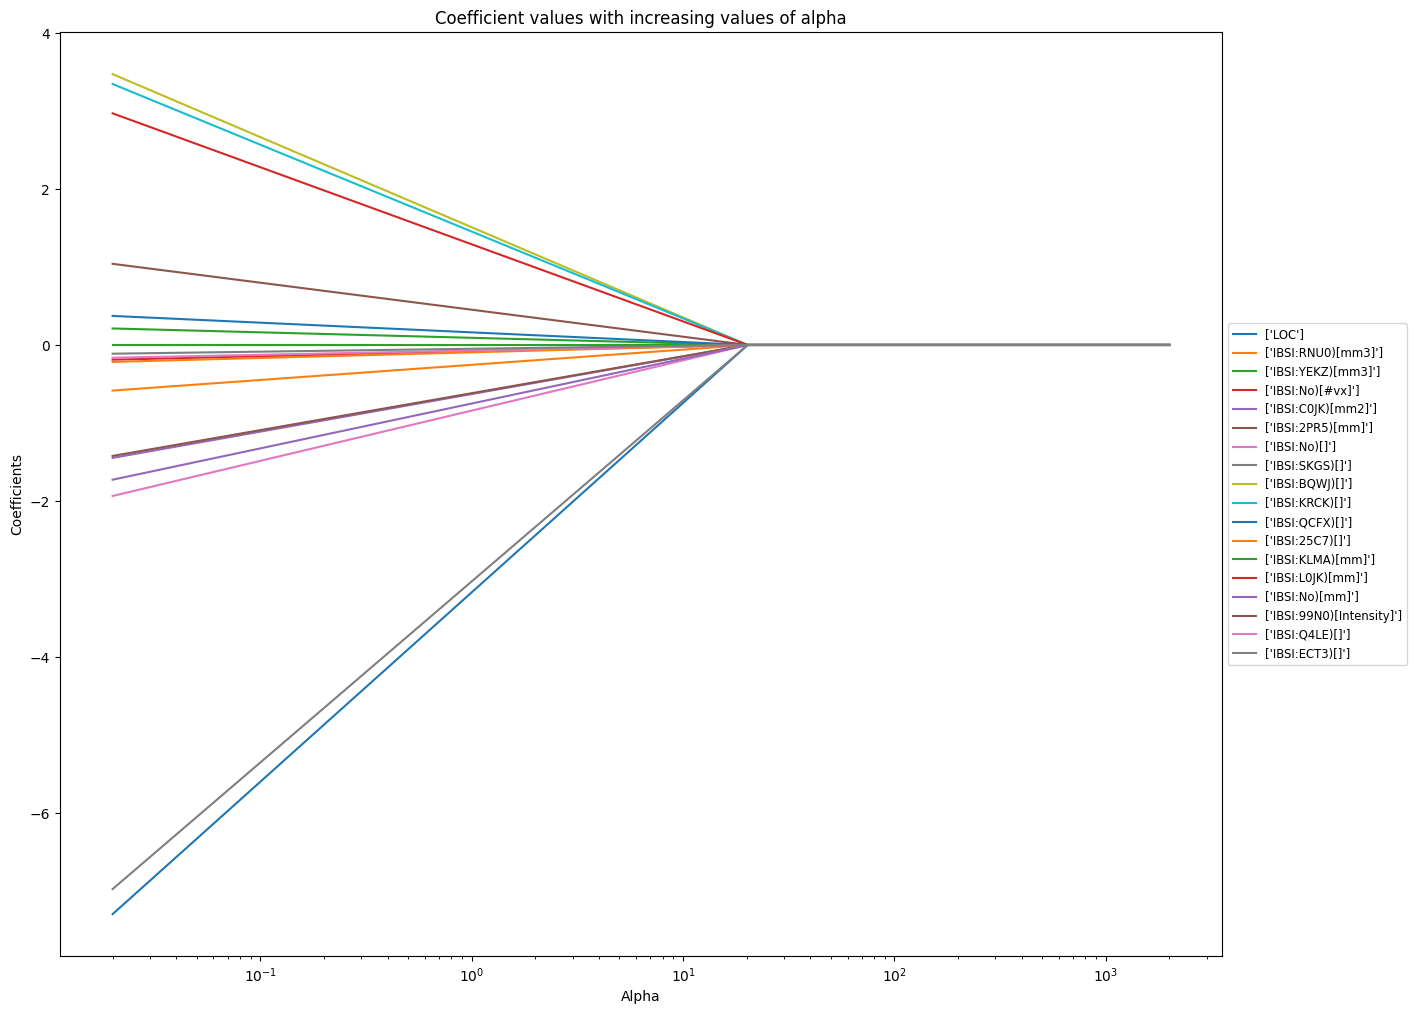

In [30]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

# Loop through each alpha value
for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

# Plot each feature's coefficient against alpha
ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()



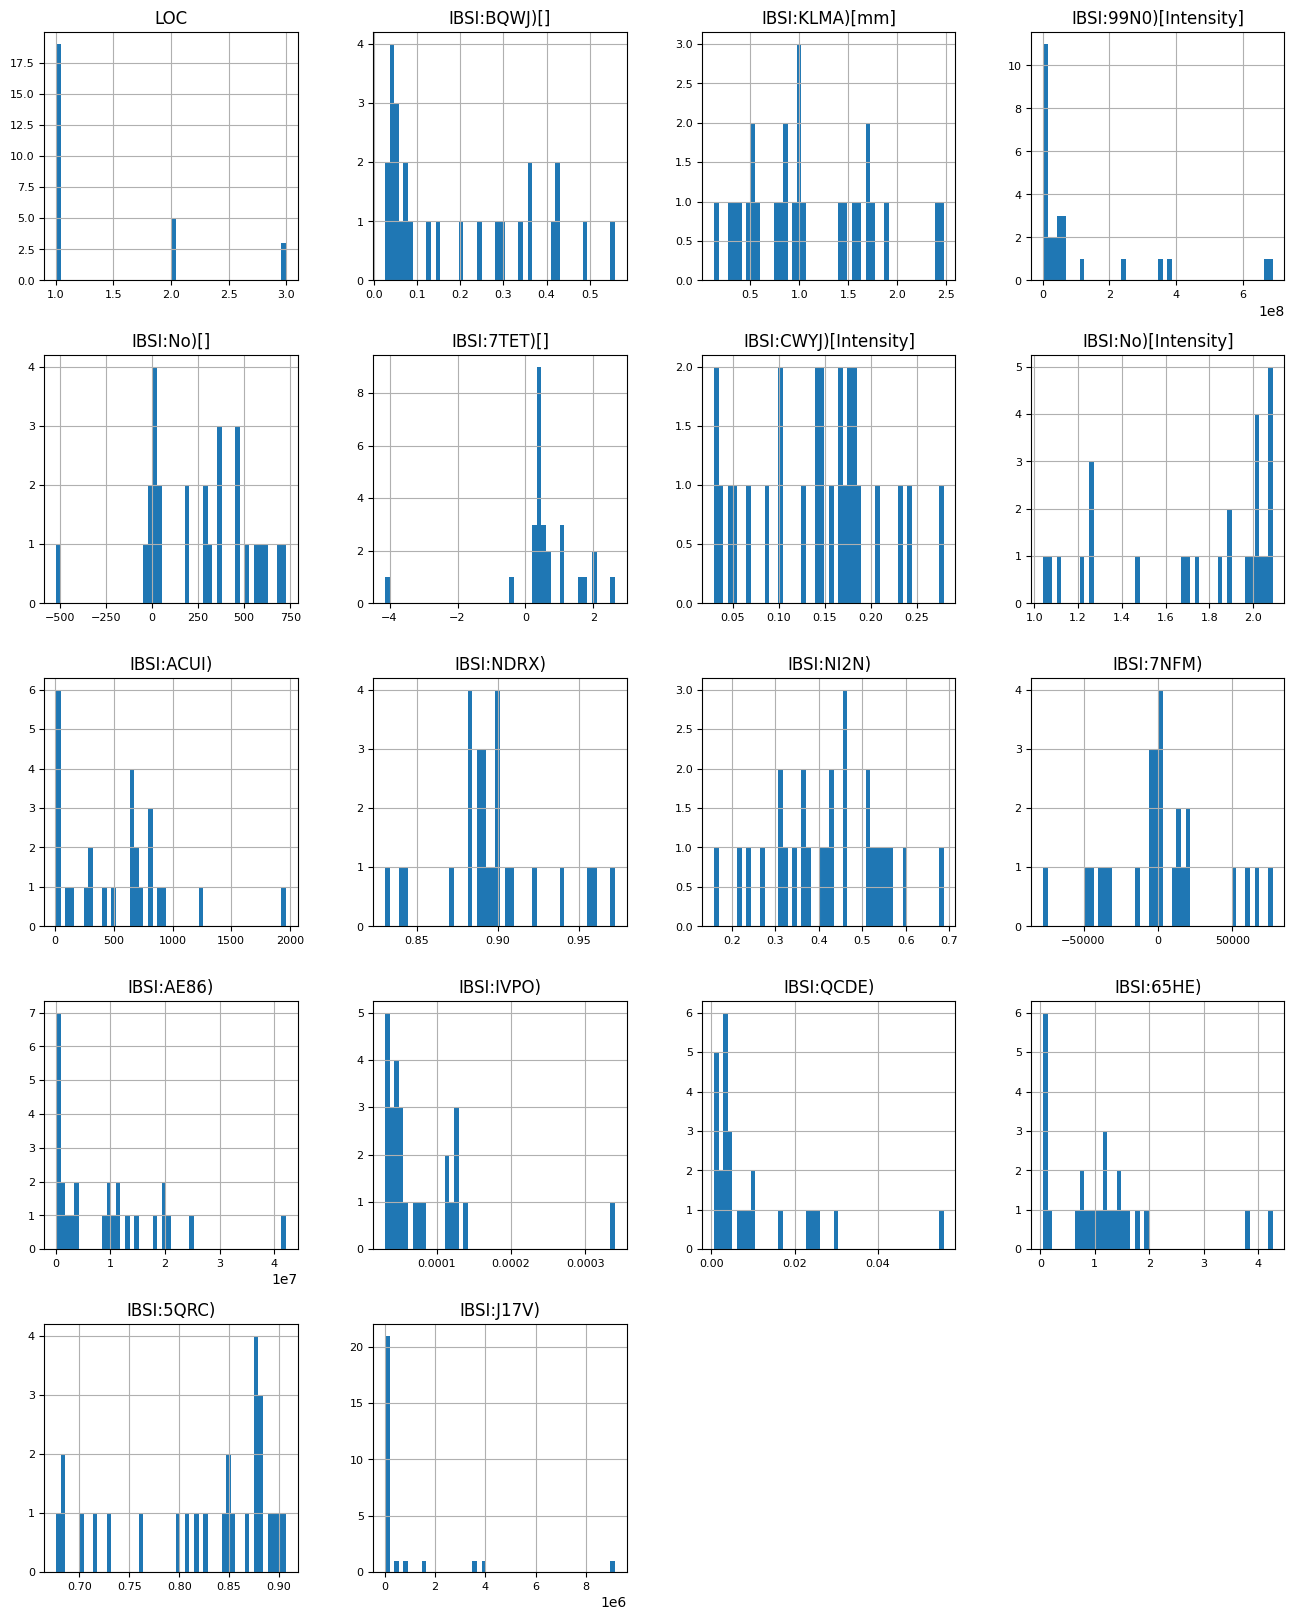

In [31]:
hist_plot(X_selected)

In [32]:
X_selected.dtypes

LOC                                                                                     int64
MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]                                               float64
MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]                                        float64
MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]                               float64
INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]                                    float64
INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]                     float64
INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]    float64
INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]                float64
GLCM_Contrast(IBSI:ACUI)                                                              float64
GLCM_NormalisedInverseDifference(IBSI:NDRX)                                           float64
GLCM_Correlation(IBSI:NI2N)                                 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


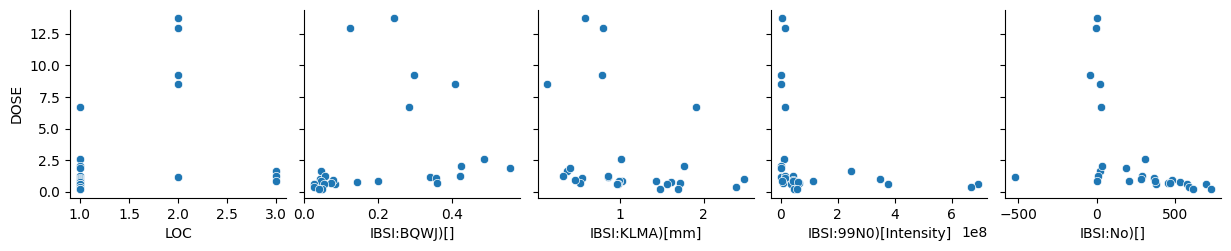

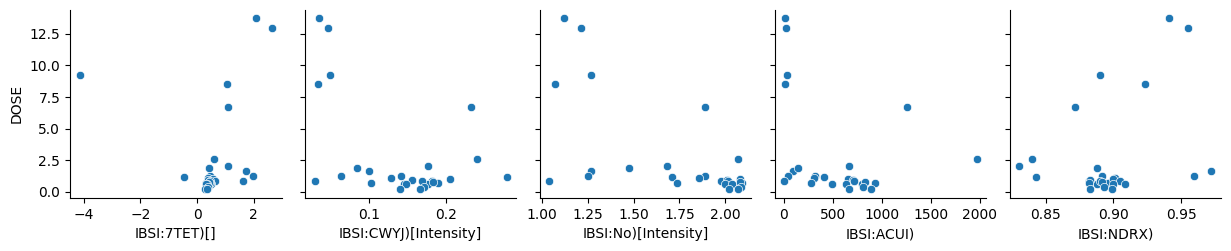

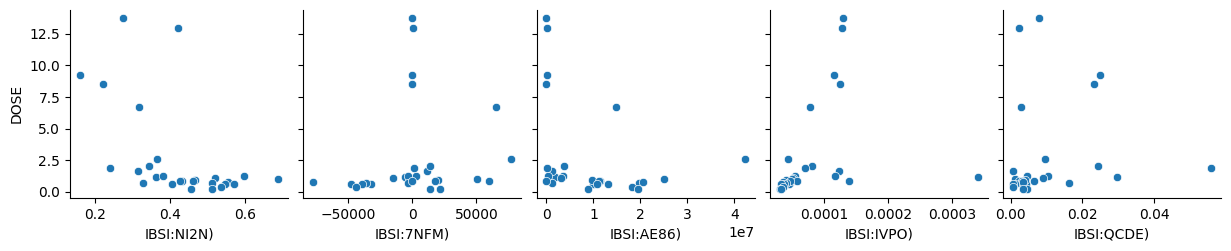

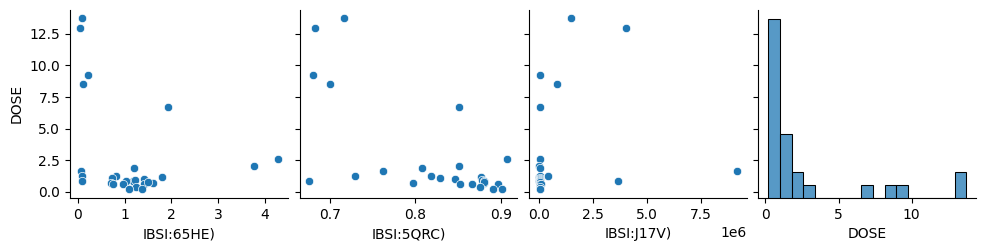

In [33]:
# Pair plots between the lasso selected features in X and the target variable DOSE.
pair_plot(X_selected, y)

In [34]:
# Encode LOC feature to one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [35]:
# Step 1 selected features
X_selected_encoded.columns

Index(['MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterShade(IBSI:7NFM)',
       'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO)',
       'NGTDM_Coarseness(IBSI:QCDE)', 'NGTDM_Contrast(IBSI:65HE)',
       'GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)', 'LOC_1', 'LOC_2',
       'LOC_3'],
      dtype='object')

In [36]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [37]:
# Evaluate the XGBRegressor model perfonmance on lasso selected features
model = XGBRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999834187683
Mean MAE: 0.0003181921905139802
Mean MSE: 2.3391063435735495e-07
Mean RMSE: 0.0004836430857123409


Mean Test Scores:
Mean R2 Score: 0.853999029476638
Mean MAE: 0.1949098518761928
Mean MSE: 0.09562653020954084
Mean RMSE: 0.30923539611360923



Text(0.5, 1.0, 'Feature Importance ')

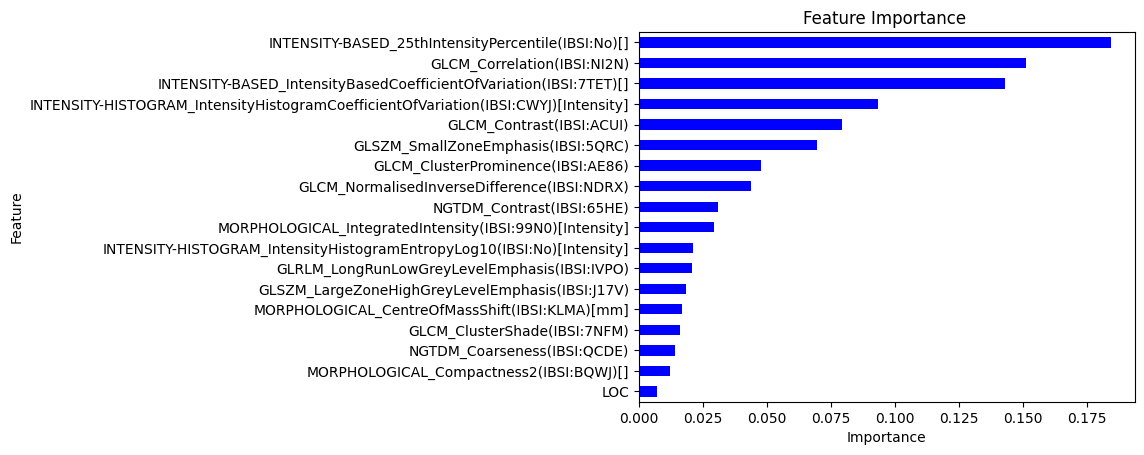

In [38]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from first step with rf feature importance > 0.02

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [39]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[] (0.184547)
2. Feature GLCM_Correlation(IBSI:NI2N) (0.151403)
3. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[] (0.143021)
4. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity] (0.093640)
5. Feature GLCM_Contrast(IBSI:ACUI) (0.079556)
6. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC) (0.069649)
7. Feature GLCM_ClusterProminence(IBSI:AE86) (0.047561)
8. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX) (0.043709)
9. Feature NGTDM_Contrast(IBSI:65HE) (0.030917)
10. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity] (0.029355)
11. Feature INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity] (0.021004)
12. Feature GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO) (0.020956)
13. Feature GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V) (0.018557)
14. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (0.016857)
15. Feature GLCM_ClusterShad

In [40]:
X_selected2 = X_selected.iloc[:, importances>0.02]

In [41]:
# Step 2 selected features
X_selected2.columns

Index(['MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO)',
       'NGTDM_Contrast(IBSI:65HE)', 'GLSZM_SmallZoneEmphasis(IBSI:5QRC)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


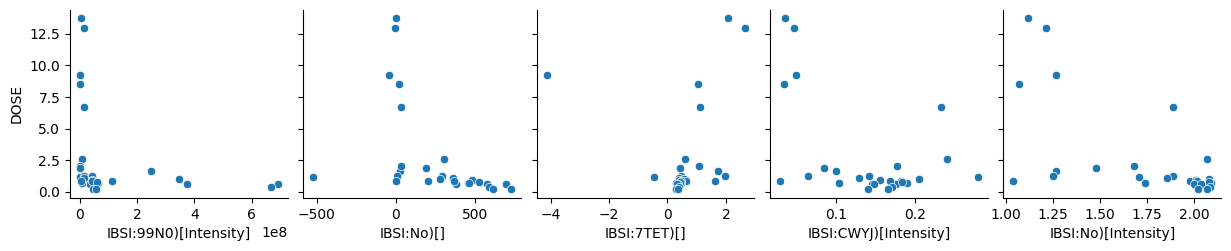

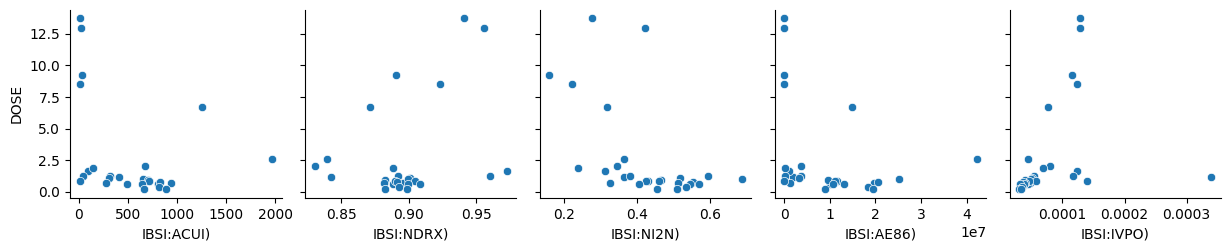

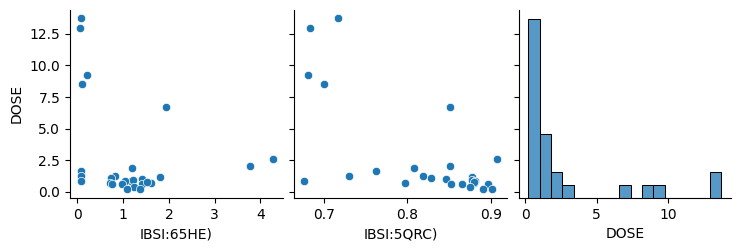

In [42]:
pair_plot(X_selected2, y)

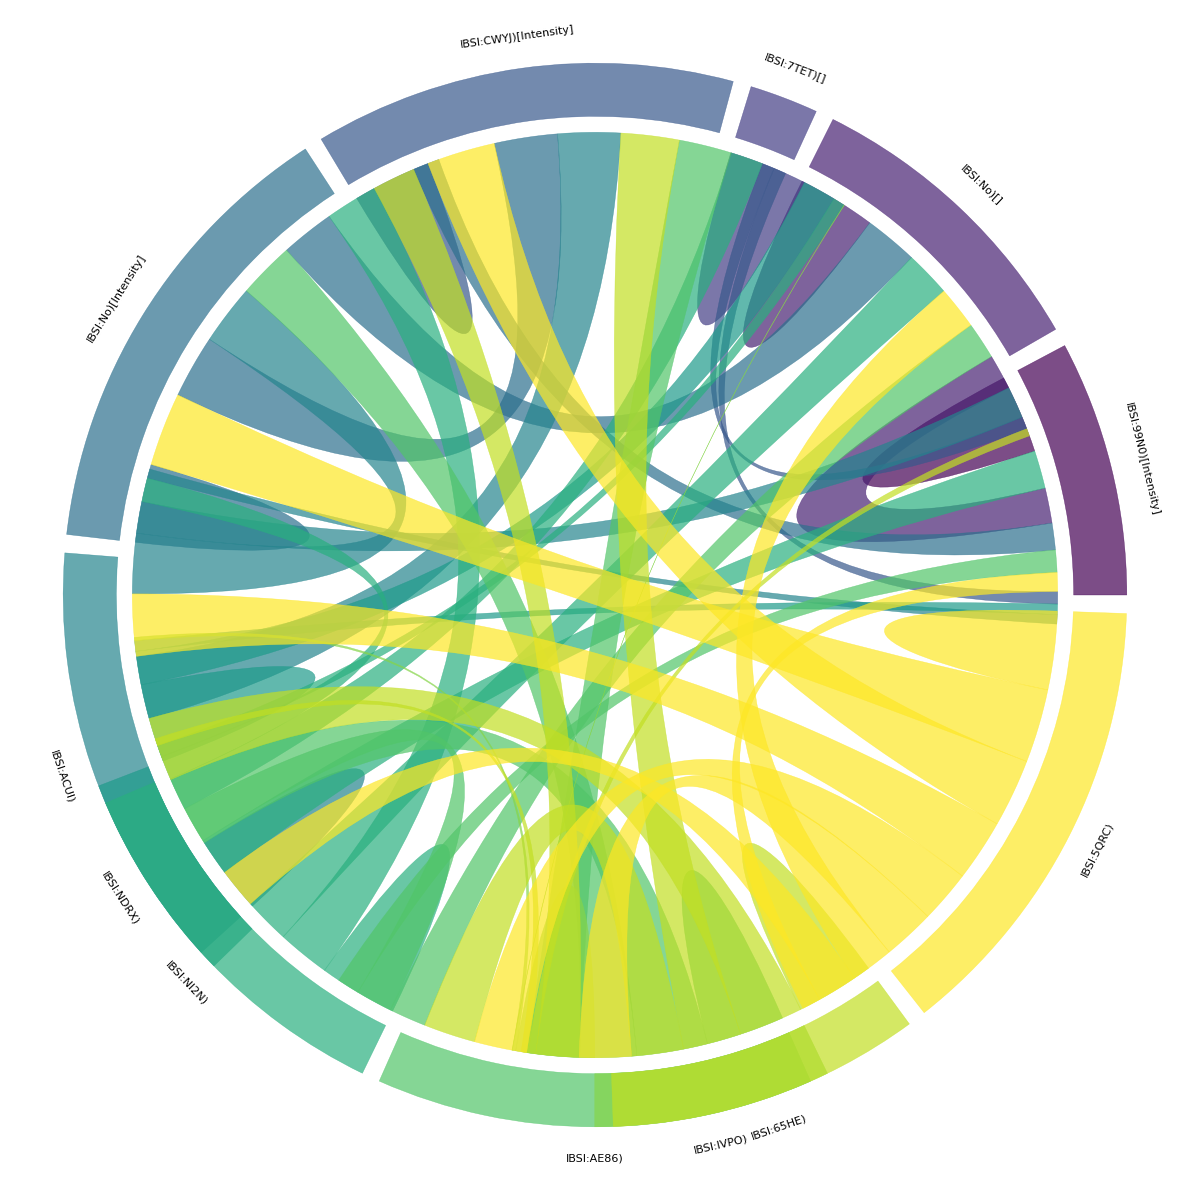

In [43]:
# Chord diagram for visualizing the correlation between selected features
plot_chord_diagram(X_selected2)

In [44]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [45]:
X_selected2_scaled = StandardScaler().fit_transform(X_selected2_encoded)

In [46]:
# Evaluate the XGBRegressor model perfonmance on random forest selected features
model = XGBRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.999999981526502
Mean MAE: 0.00036569573352126904
Mean MSE: 2.628075412649104e-07
Mean RMSE: 0.0005126475799854225


Mean Test Scores:
Mean R2 Score: 0.7838931624110331
Mean MAE: 0.22486098536062632
Mean MSE: 0.14608389903046734
Mean RMSE: 0.382209234622173



In [47]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator = XGBRegressor()  
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]
2. Feature INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]
3. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]
4. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]
5. Feature INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]
6. Feature GLCM_Contrast(IBSI:ACUI)
7. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX)
8. Feature GLCM_Correlation(IBSI:NI2N)


In [48]:
X_selected3 = X_selected2[selected_features]

In [49]:
X_selected3.shape

(27, 8)

In [50]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [51]:
X_selected3_sorted.shape

(27, 8)

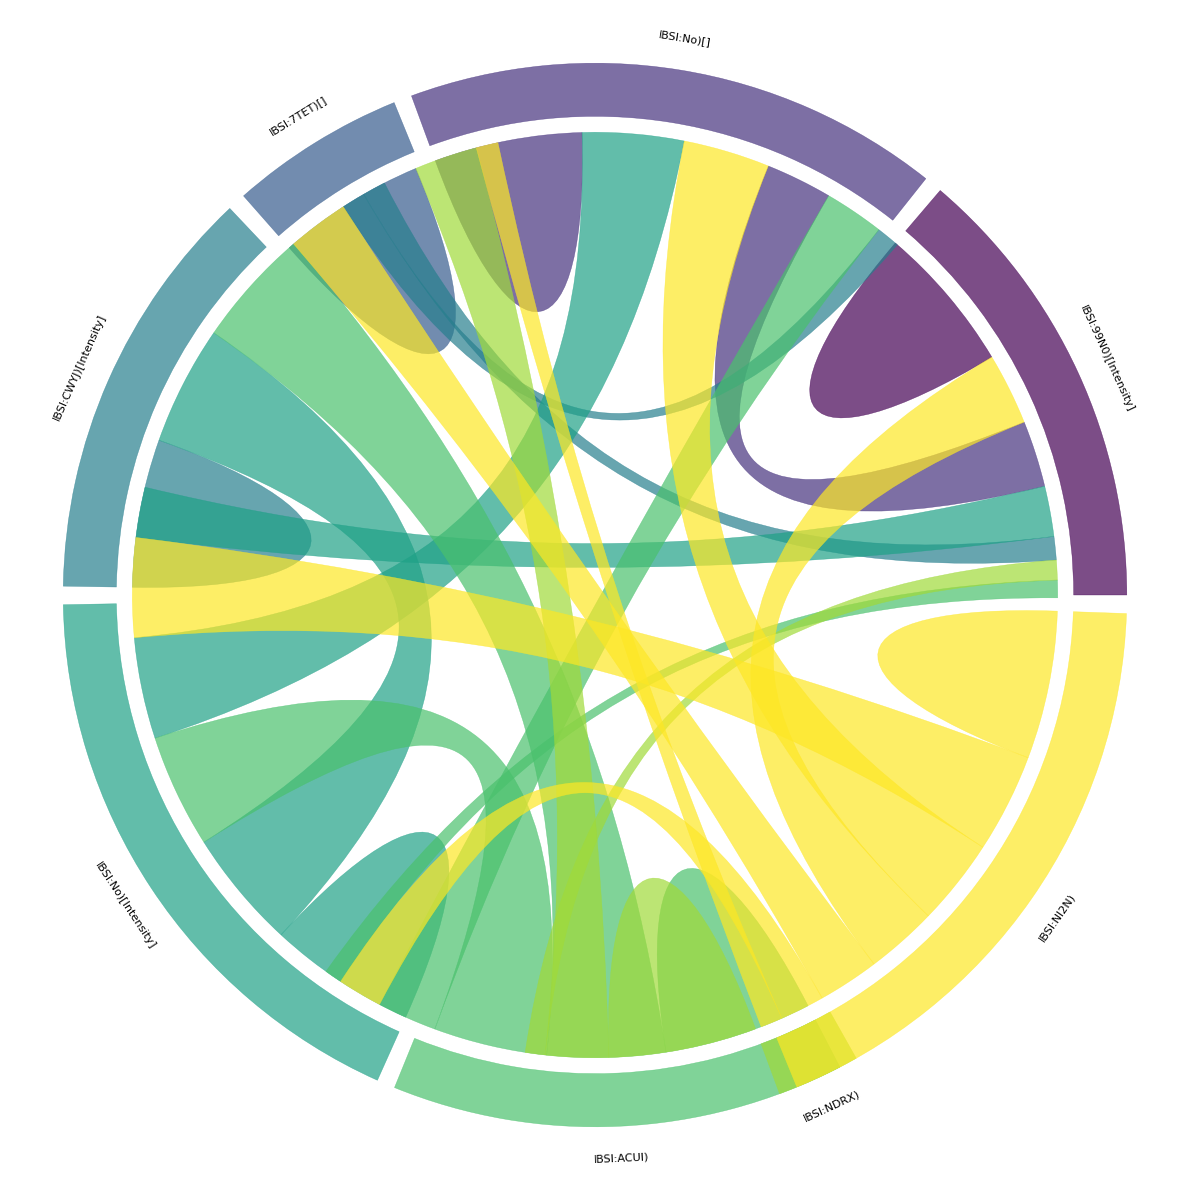

In [52]:
plot_chord_diagram(X_selected3)

In [53]:
# Final 8 selected features
X_selected3.columns

Index(['MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLCM_Contrast(IBSI:ACUI)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)'],
      dtype='object')

In [54]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [55]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [56]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cnt = 1
for train_index, test_index in kf.split(X_selected3, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    cnt += 1

Fold:1, Train set: 21, Test set:6
Fold:2, Train set: 21, Test set:6
Fold:3, Train set: 22, Test set:5
Fold:4, Train set: 22, Test set:5
Fold:5, Train set: 22, Test set:5


In [57]:
# Final evaluation after 3 step feature selection using XGBRegressor as a model
# On final 8 selected features
model = XGBRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999811383575
Mean MAE: 0.00036903639469310827
Mean MSE: 2.7076051205289867e-07
Mean RMSE: 0.0005203465307397548


Mean Test Scores:
Mean R2 Score: 0.7766986315014357
Mean MAE: 0.22953604090420793
Mean MSE: 0.14841812221182224
Mean RMSE: 0.38525072642607994



Section 2: One Step Feature Selection Using Recursive Feature Elimination (RFE) 

Model: XGBRegressor trained using k fold cross-validation with bootstrapping

In [60]:
# Recursive Feature Elimination (RFE) on the entire dataset
# Using XGBRegressor as the estimator and select 8 top features
estimator = XGBRegressor()
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_scaled, y)  
selected_features = X.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))

1. Feature LOC
2. Feature INTENSITY-BASED_MeanIntensity(IBSI:Q4LE)[]
3. Feature INTENSITY-BASED_IntensityVariance(IBSI:ECT3)[]
4. Feature INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]
5. Feature INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]
6. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]
7. Feature INTENSITY-BASED_IntensityBasedQuartileCoefficientOfDispersion(IBSI:9S40)[]
8. Feature INTENSITY-BASED_IntensityBasedEnergy(IBSI:N8CA)[]


In [61]:
X_selected = X[selected_features]

In [62]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected_sorted = X.iloc[:, sorted_selected_indices]

In [63]:
X_selected_sorted.shape

(27, 8)

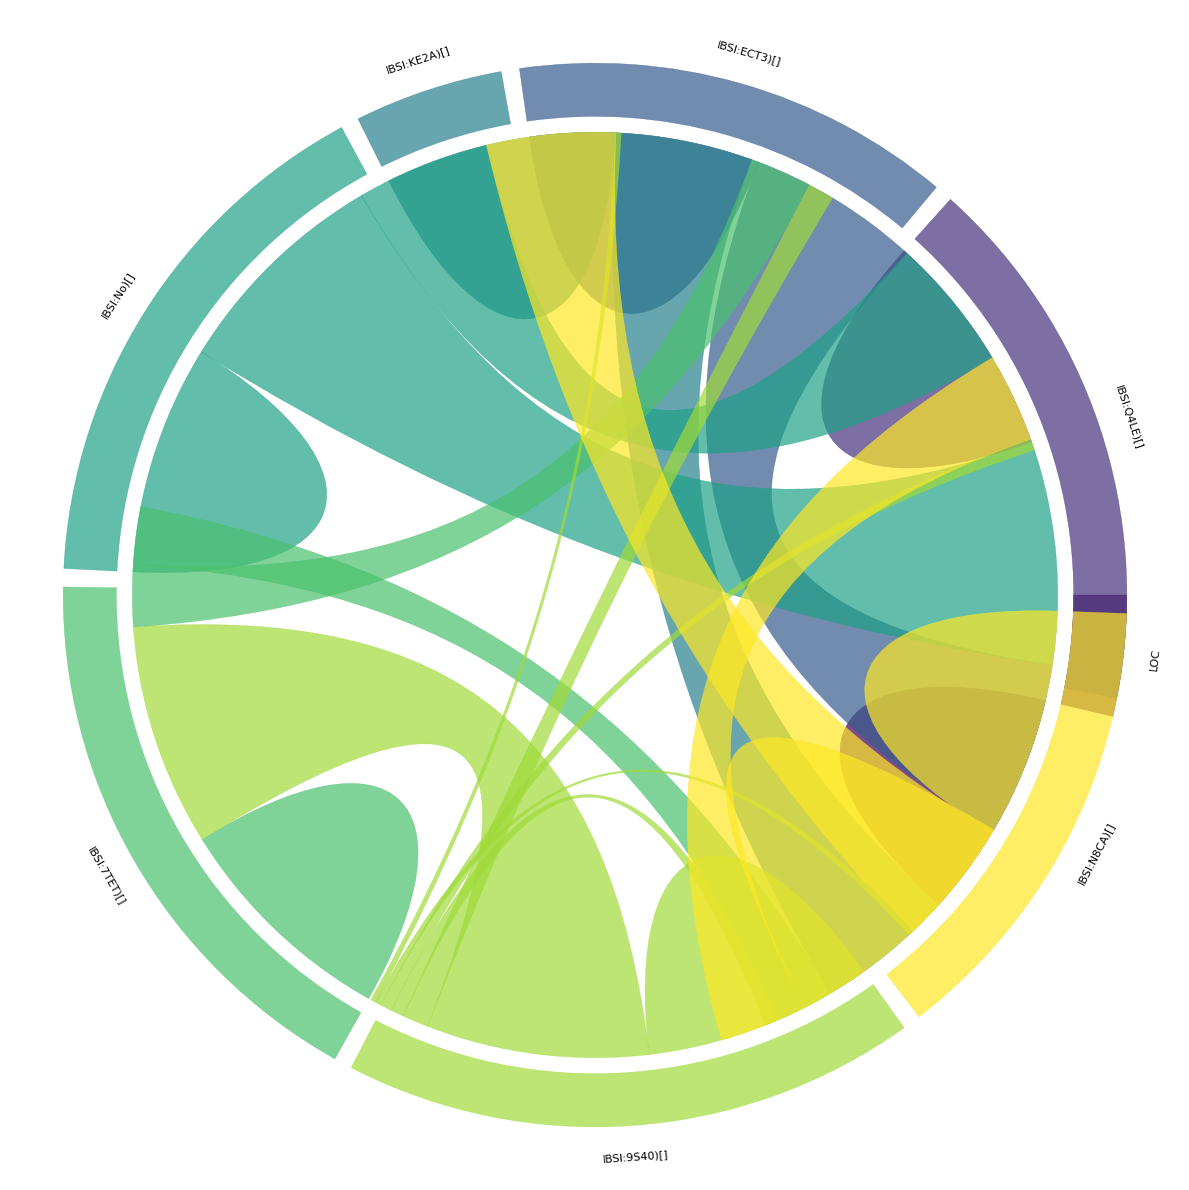

In [64]:
# Correlation between selected features
plot_chord_diagram(X_selected)

In [65]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_sorted)

In [66]:
# Evaluate the model perfonmance on 8 selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.999999996657919
Mean MAE: 0.00016121290762523903
Mean MSE: 4.543927153099313e-08
Mean RMSE: 0.00021316489282007276


Mean Test Scores:
Mean R2 Score: 0.6807744281689806
Mean MAE: 0.184399533173582
Mean MSE: 0.13943466824264458
Mean RMSE: 0.3734095181468257



Section 3: Three-Step Feature Selection using Lasso Regression (Starting from 50% feature removal), Random Forest and Recursive Feature Elimination (RFE) 

Model: GradientBoostingRegressor trained using k fold cross-validation with bootstrapping

In [69]:
# Step1: Remove 50% of features using lasso
lasso = Lasso(alpha=0.05, max_iter=10000) 
lasso.fit(X_scaled, y)

selected_features = X.columns[lasso.coef_ != 0]

feature_coefficients = pd.Series(lasso.coef_, index=X.columns)
sorted_coeffs = feature_coefficients.abs().sort_values(ascending=False)
num_features_to_keep = len(X.columns) // 2
selected_features = sorted_coeffs[:num_features_to_keep].index

for f, feature in enumerate(selected_features):
    print("%d. Feature %s (%f)" % (f + 1, feature, lasso.coef_[f]))

1. Feature LOC (-5.431936)
2. Feature INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity] (-0.000000)
3. Feature GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO) (-0.000000)
4. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC) (-0.000000)
5. Feature NGTDM_Coarseness(IBSI:QCDE) (-0.000000)
6. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX) (0.000000)
7. Feature GLCM_Correlation(IBSI:NI2N) (-0.000000)
8. Feature GLCM_ClusterProminence(IBSI:AE86) (-0.000000)
9. Feature GLCM_Contrast(IBSI:ACUI) (-0.159213)
10. Feature INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[] (-0.000000)
11. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity] (-0.000000)
12. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[] (-0.000000)
13. Feature MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm] (0.175479)
14. Feature MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[] (-0.000000)
15. Feature NGTDM_Contrast(IBSI:65HE) (-0.000000)
16. Feature MORPHOLOGICA

In [70]:
eli5.show_weights(lasso, top=-1, feature_names = X.columns.tolist())

In [71]:
X_selected = X[selected_features]

In [72]:
# Step 1 selected features
X_selected.columns

Index(['LOC',
       'INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO)',
       'GLSZM_SmallZoneEmphasis(IBSI:5QRC)', 'NGTDM_Coarseness(IBSI:QCDE)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]', 'NGTDM_Contrast(IBSI:65HE)',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'GLCM_ClusterShade(IBSI:7NFM)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLCM_InverseDifferenceMoment(IBSI:WF0Z)',
       'GLCM_InverseDifference(

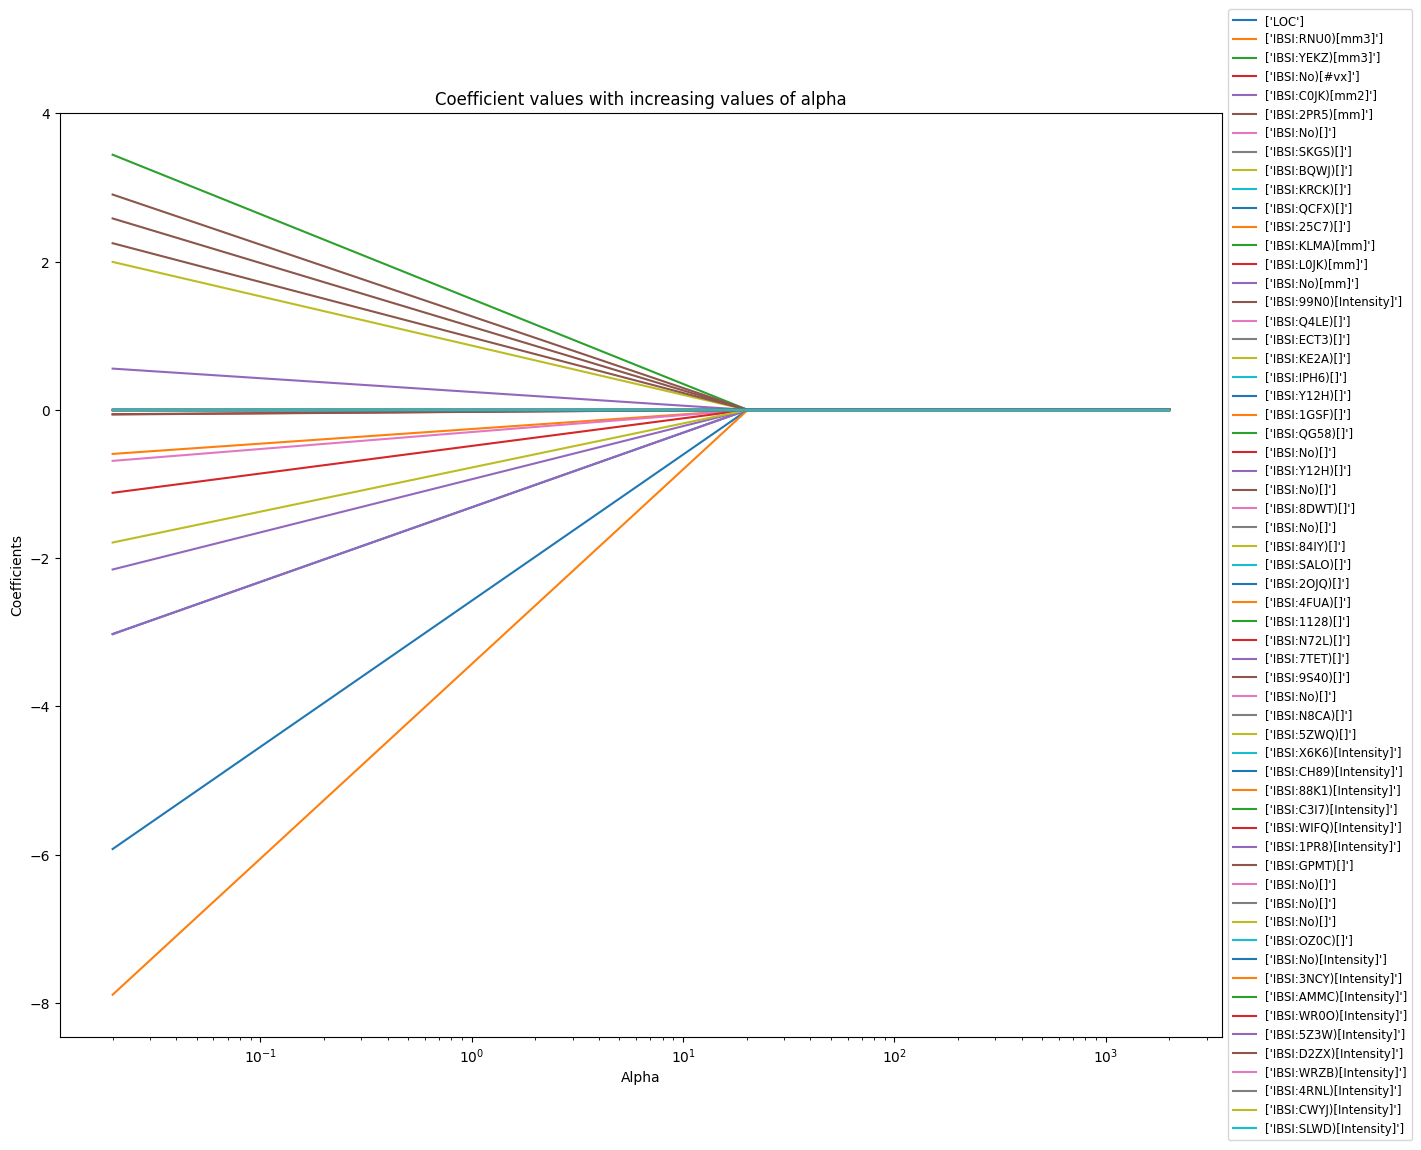

In [73]:
plt.figure(figsize=(15, 12))  

alphas = np.linspace(0.01, 1000, 100)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(StandardScaler().fit_transform(X_selected), y)
    coefs.append(lasso.coef_)

ax = plt.gca()
for idx, feature_coef in enumerate(np.array(coefs).T):
    ax.plot(alphas*2, feature_coef, label=get_simple_feature_name([X.columns[idx]]))

ax.set_xscale('log')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small') 
ax.grid(False)
plt.axis('tight')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title("Coefficient values with increasing values of alpha")
plt.show()

In [74]:
# Encode the LOC feature using one hot encoding
X_selected_encoded = one_hot_encoding(X_selected, 'LOC')

In [75]:
X_selected_encoded.columns

Index(['INTENSITY-HISTOGRAM_IntensityHistogramEntropyLog10(IBSI:No)[Intensity]',
       'GLRLM_LongRunLowGreyLevelEmphasis(IBSI:IVPO)',
       'GLSZM_SmallZoneEmphasis(IBSI:5QRC)', 'NGTDM_Coarseness(IBSI:QCDE)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-BASED_25thIntensityPercentile(IBSI:No)[]',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'MORPHOLOGICAL_CentreOfMassShift(IBSI:KLMA)[mm]',
       'MORPHOLOGICAL_Compactness2(IBSI:BQWJ)[]', 'NGTDM_Contrast(IBSI:65HE)',
       'MORPHOLOGICAL_IntegratedIntensity(IBSI:99N0)[Intensity]',
       'GLCM_ClusterShade(IBSI:7NFM)',
       'GLSZM_LargeZoneHighGreyLevelEmphasis(IBSI:J17V)',
       'GLCM_InverseDifferenceMoment(IBSI:WF0Z)',
       'GLCM_InverseDifference(IBSI:IB1Z)', '

In [76]:
# Scale the data using standard scaler
X_selected_scaled = StandardScaler().fit_transform(X_selected_encoded)

In [77]:
# Evaluate the model perfonmance on lasso selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999990436721
Mean MAE: 8.685980730033563e-05
Mean MSE: 1.4424556173285503e-08
Mean RMSE: 0.00012010227380564242


Mean Test Scores:
Mean R2 Score: 0.8534906522620057
Mean MAE: 0.18426860475193657
Mean MSE: 0.11217886707680556
Mean RMSE: 0.33493113781314143



Text(0.5, 1.0, 'Feature Importance ')

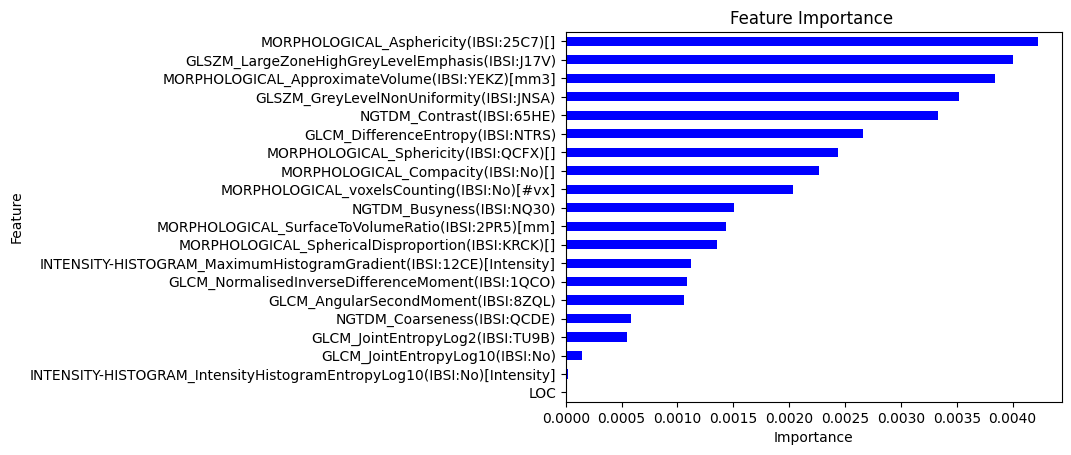

In [78]:
# Step 2: Train a Random Forest regressor with 100 decision trees 
# Select features from step 1 with rf feature importance > 0.02
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_selected, y)

importances_df = pd.Series(rf.feature_importances_, index=X_selected.columns)
importances_df.sort_values(ascending=True, inplace=True)
importances_df[:20].plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance ")

In [79]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X_selected.shape[1]):
    print("%d. Feature %s (%f)" % (f + 1, X_selected.columns.values[indices[f]], 
          importances[indices[f]]))

1. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[] (0.122738)
2. Feature GLCM_Correlation(IBSI:NI2N) (0.092046)
3. Feature INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[] (0.058069)
4. Feature GLCM_JointVariance(IBSI:UR99) (0.046155)
5. Feature GLRLM_LongRunHighGreyLevelEmphasis(IBSI:3KUM) (0.041832)
6. Feature INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity] (0.039661)
7. Feature INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[] (0.034465)
8. Feature GLCM_DifferenceVariance(IBSI:D3YU) (0.032165)
9. Feature GLCM_Contrast(IBSI:ACUI) (0.032069)
10. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX) (0.029717)
11. Feature INTENSITY-BASED_MeanIntensity(IBSI:Q4LE)[] (0.026221)
12. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC) (0.025988)
13. Feature GLRLM_RunPercentage(IBSI:9ZK5) (0.025532)
14. Feature GLCM_Autocorrelation(IBSI:QWB0) (0.023893)
15. Feature GLCM_JointAverage(IBSI:60VM) (0.022194)
16. Feature GLCM_ClusterProminence(IBSI:AE8

In [80]:
X_selected2 = X_selected.iloc[:, importances>0.02]

In [81]:
# Step 2 selected features
X_selected2.columns

Index(['GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_ClusterProminence(IBSI:AE86)',
       'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-HISTOGRAM_IntensityHistogramCoefficientOfVariation(IBSI:CWYJ)[Intensity]',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]',
       'INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]',
       'INTENSITY-BASED_MeanIntensity(IBSI:Q4LE)[]',
       'GLCM_DifferenceVariance(IBSI:D3YU)', 'GLCM_JointVariance(IBSI:UR99)',
       'GLCM_JointAverage(IBSI:60VM)',
       'INTENSITY-HISTOGRAM_MinimumHistogramGradient(IBSI:VQB3)[Intensity]',
       'GLRLM_RunPercentage(IBSI:9ZK5)', 'GLCM_Autocorrelation(IBSI:QWB0)',
       'GLRLM_LongRunHighGreyLevelEmphasis(IBSI:3KUM)'],
      dtype='object')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


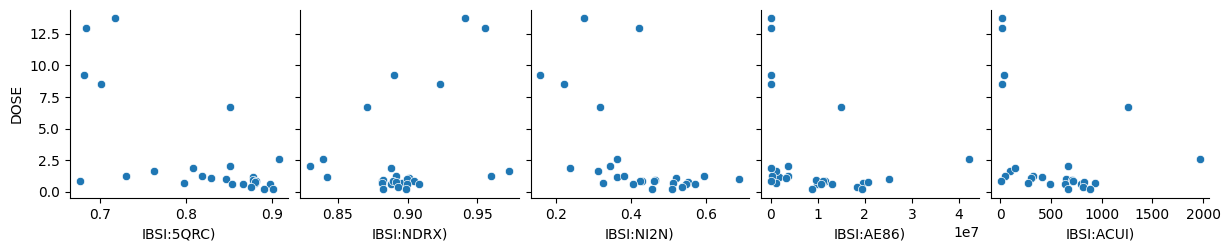

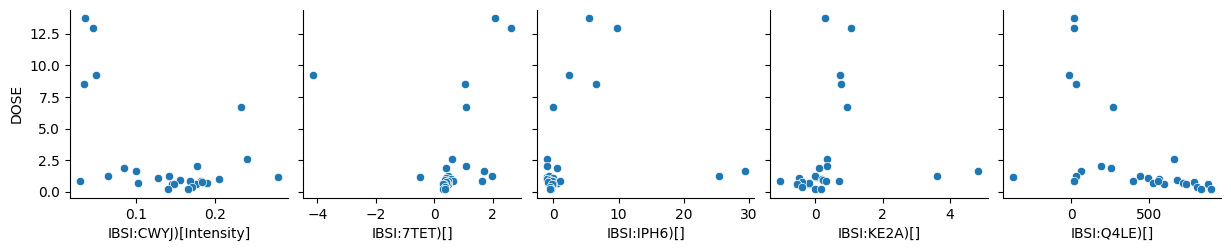

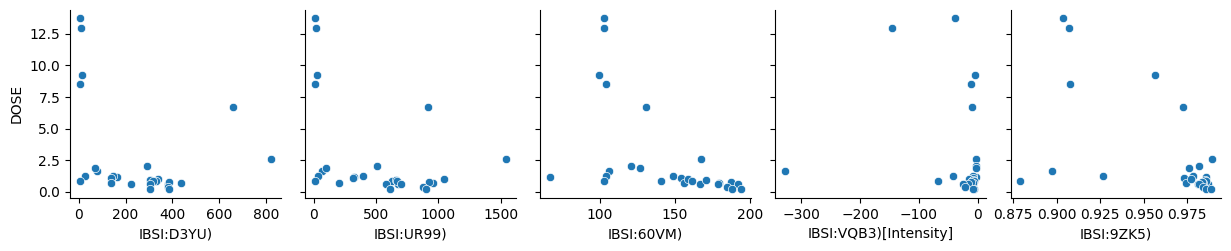

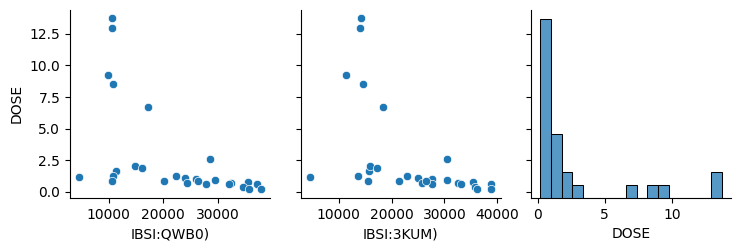

In [82]:
pair_plot(X_selected2, y)

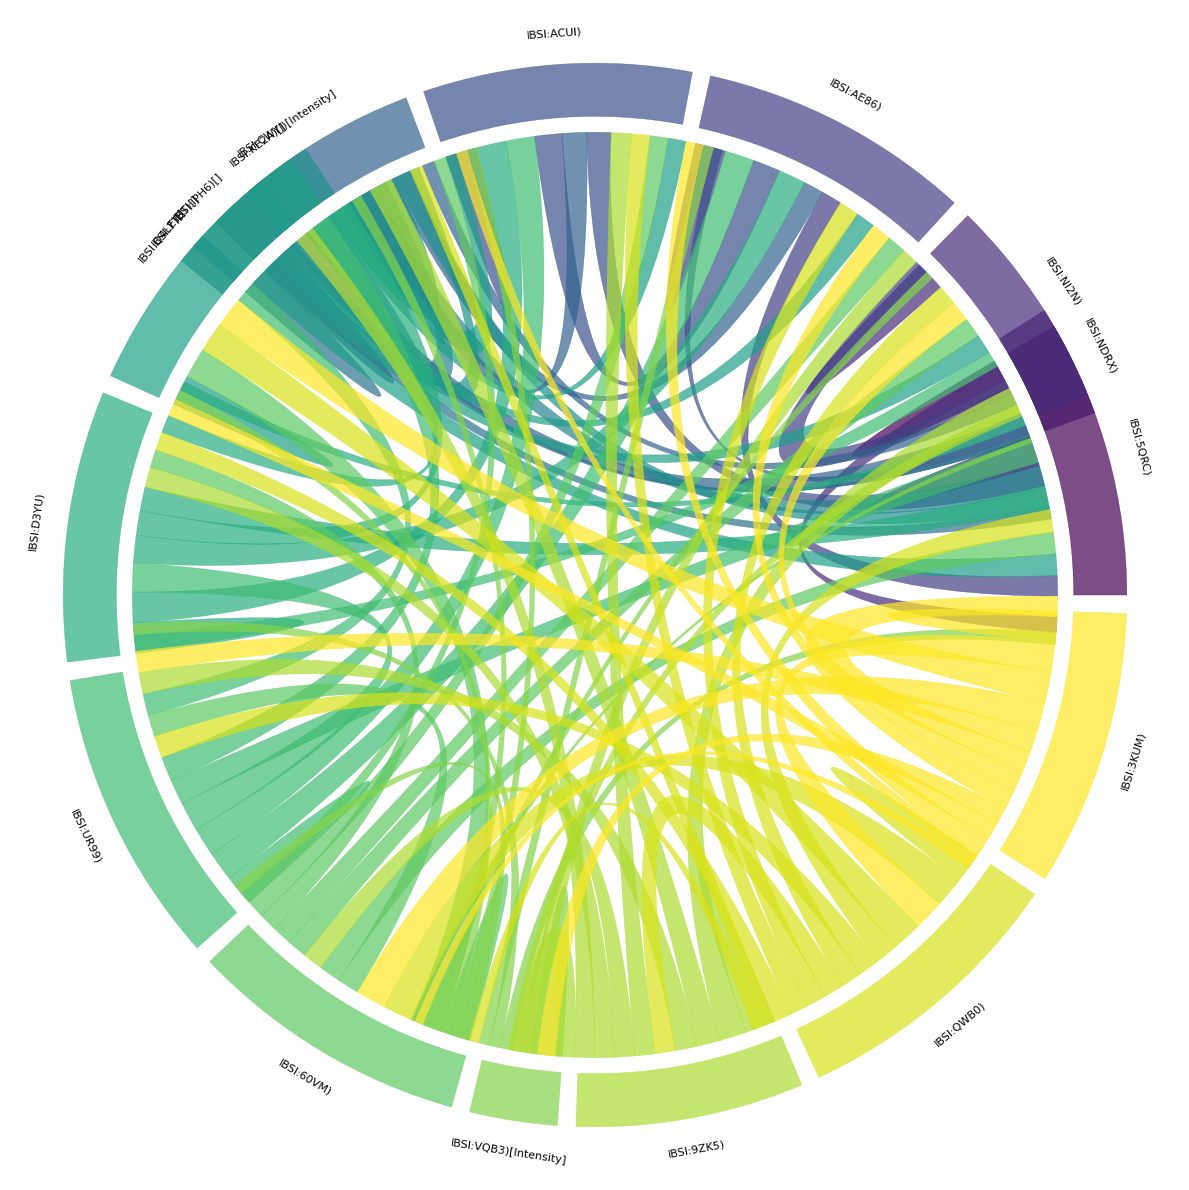

In [83]:
plot_chord_diagram(X_selected2)

In [84]:
X_selected2_encoded = one_hot_encoding(X_selected2, 'LOC')

In [85]:
# Evaluate model perfonmace on random forest selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected2_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999979863413
Mean MAE: 0.00014012288962136525
Mean MSE: 3.213667659671468e-08
Mean RMSE: 0.0001792670538518294


Mean Test Scores:
Mean R2 Score: -0.5603037830959956
Mean MAE: 0.3126942458236119
Mean MSE: 0.6971589165157492
Mean RMSE: 0.8349604281136619



In [86]:
# Step 3: Recursive Feature Elimination (RFE) Using XGBRegressor as the estimator
# Select 8 top features from step 2 selected features
estimator=XGBRegressor()
rfe = RFE(estimator, n_features_to_select=8) 

rfe.fit(X_selected2, y)  
selected_features = X_selected2.columns[rfe.support_]

for f, feature in enumerate(selected_features):
    print("%d. Feature %s" % (f + 1, feature))


1. Feature GLSZM_SmallZoneEmphasis(IBSI:5QRC)
2. Feature GLCM_NormalisedInverseDifference(IBSI:NDRX)
3. Feature GLCM_Correlation(IBSI:NI2N)
4. Feature GLCM_Contrast(IBSI:ACUI)
5. Feature INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]
6. Feature INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]
7. Feature INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]
8. Feature INTENSITY-BASED_MeanIntensity(IBSI:Q4LE)[]


In [87]:
X_selected3 = X_selected2[selected_features]

In [88]:
# Sort X based on the rfe ranking for furthur visualization
rfe_rankings = rfe.ranking_
selected_indices = np.where(rfe.support_)[0]
sorted_selected_indices = selected_indices[np.argsort(rfe_rankings[selected_indices])]
X_selected3_sorted = X_selected2.iloc[:, sorted_selected_indices]

In [89]:
X_selected3_sorted.shape

(27, 8)

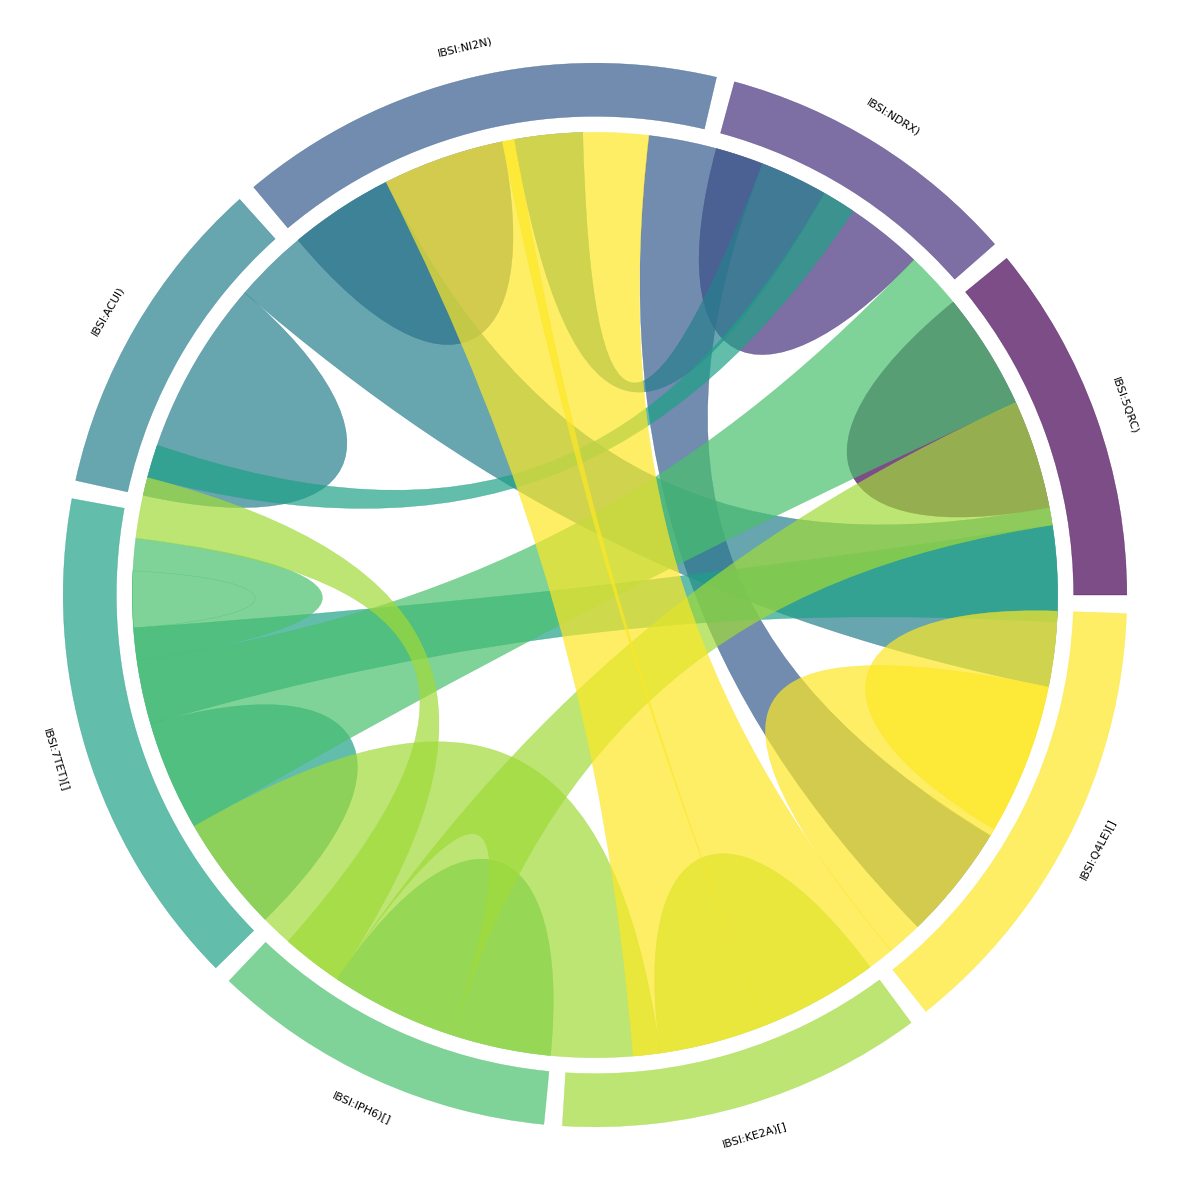

In [90]:
# Correlation plot of final selected features
plot_chord_diagram(X_selected3)

In [91]:
# Final 8 seleted features
X_selected3.columns

Index(['GLSZM_SmallZoneEmphasis(IBSI:5QRC)',
       'GLCM_NormalisedInverseDifference(IBSI:NDRX)',
       'GLCM_Correlation(IBSI:NI2N)', 'GLCM_Contrast(IBSI:ACUI)',
       'INTENSITY-BASED_IntensityBasedCoefficientOfVariation(IBSI:7TET)[]',
       'INTENSITY-BASED_IntensityKurtosis(IBSI:IPH6)[]',
       'INTENSITY-BASED_IntensitySkewness(IBSI:KE2A)[]',
       'INTENSITY-BASED_MeanIntensity(IBSI:Q4LE)[]'],
      dtype='object')

In [92]:
X_selected3_encoded = one_hot_encoding(X_selected3_sorted, 'LOC')

In [93]:
X_selected3_scaled = StandardScaler().fit_transform(X_selected3_encoded)

In [94]:
# Evaluation on 8 final selected features
model = GradientBoostingRegressor(random_state=42)
r2, mse = evaluate_model(X_selected3_scaled, y, model)    


Mean Train Scores:
Mean R2 Score: 0.9999999980890327
Mean MAE: 0.00014297361005351263
Mean MSE: 2.9908663358693726e-08
Mean RMSE: 0.00017294121359205767


Mean Test Scores:
Mean R2 Score: 0.7300815949169887
Mean MAE: 0.1768804612574925
Mean MSE: 0.07701571058426285
Mean RMSE: 0.27751704557425455

